In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
# input
data_d <- '/scratch/groups/mrivas/projects/biobank-methods-dev/20200526-snpnet-weights'
phe_f  <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.20200522.phe'

# constants
covars <- c('age', 'sex', paste0('PC', 1:10))
alphas <- c('weightedF', 'weightedT')

# output
out_f <- 'snpnet-weighted.eval.tsv'


In [3]:
read_PRS <- function(GBE_ID, alpha, data_dir=data_d){
    sscore_f <- file.path(
        data_dir,
        sprintf('%s_%s', GBE_ID, alpha),
        sprintf('%s.sscore.zst', GBE_ID)
    )
    fread(
        cmd=paste('zstdcat', sscore_f),
        select=c('#FID', 'IID', 'SCORE1_SUM'),
        colClasses=c('#FID'='character', 'IID'='character')
    ) %>%
    rename('FID'='#FID', 'geno_score'='SCORE1_SUM')
}


In [4]:
read_covars <- function(GBE_ID, alpha, data_dir=data_d){
    file.path(
        data_dir,
        sprintf('%s_%s', GBE_ID, alpha),
        'snpnet.covars.tsv'
    ) %>%
    fread(colClasses=c('ID'='character')) %>%
    column_to_rownames('ID')
}


In [5]:
read_BETAs <- function(GBE_ID, alpha, data_dir=data_d){
    file.path(
        data_dir,
        sprintf('%s_%s', GBE_ID, alpha),
        'snpnet.tsv'
    ) %>%
    fread(colClasses=c('ID'='character'))
}


In [6]:
read_predicted_scores <- function(phe_df, GBE_ID, alpha, covariates=covars){
    covar_df <- read_covars(GBE_ID, alpha)
    as.matrix(
        phe_df %>% select(all_of(covariates))
    ) %*% as.matrix(covar_df) %>%
    as.data.frame() %>%
    rownames_to_column('ID') %>%
    separate(ID, c('FID', 'IID'), sep='_') %>% 
    rename('covar_score'='BETA') %>%
    left_join(
        phe_df %>% select(FID, IID, split, all_of(GBE_ID)),
        by=c('FID', 'IID')
    ) %>%
    left_join(
        read_PRS(GBE_ID, alpha),
        by=c('FID', 'IID')
    ) %>%
    mutate(
        geno_covar_score = geno_score + covar_score
    )
}


In [7]:
perform_eval <- function(response, pred, metric.type){
    if(metric.type == 'r2'){
        summary(lm(response ~ 1 + pred))$r.squared
    }else{
#         pROC::auc(pROC::roc(response, pred))        
        pred.obj <- ROCR::prediction(pred, factor(response - 1))
        auc.obj <- ROCR::performance(pred.obj, measure = 'auc')
        auc.obj@y.values[[1]]
    }
}


In [8]:
build_eval_df <- function(phe_df, GBE_ID, alpha, split_string, metric.type){
    score_test_df <- phe_df %>%
    read_predicted_scores(GBE_ID, alpha) %>%
    filter(split == split_string) %>%
    drop_na(all_of(GBE_ID)) %>%
    filter(GBE_ID != -9)

    data.frame(
        GBE_ID     = GBE_ID,
        alpha      = alpha,
        n_variables = read_BETAs(GBE_ID, alpha) %>% nrow(),
        geno       = perform_eval(
            score_test_df[[GBE_ID]],
            score_test_df$geno_score,
            metric.type
        ),
        covar      = perform_eval(
            score_test_df[[GBE_ID]],
            score_test_df$covar_score,
            metric.type
        ),
        geno_covar = perform_eval(
            score_test_df[[GBE_ID]],
            score_test_df$geno_covar_score,
            metric.type
        ),
        stringsAsFactors = F
    )    
}


In [9]:
get_eval_df <- function(phe_df, alphas, split_string){
    eval_df <- bind_rows(
        alphas %>% lapply(function(alpha){ tryCatch({ 
            phe_df %>% build_eval_df('INI30780', alpha, split_string, 'r2')
        }, error=function(e){})}) %>% bind_rows(),

        alphas %>% lapply(function(alpha){ tryCatch({ 
            phe_df %>% build_eval_df('HC382', alpha, split_string, 'auc')
        }, error=function(e){})}) %>% bind_rows()
    )
}


## compute the performance metric

In [10]:
phe_df <- fread(
    phe_f,
    colClasses=c('#FID'='character', 'IID'='character'),
    select=c('#FID','IID','split','INI30780','HC382', covars)
) %>%
rename('FID'='#FID') %>%
mutate(ID = paste(FID, IID, sep='_')) %>%
column_to_rownames('ID')


In [11]:
eval_df <- bind_rows(
    phe_df %>% get_eval_df(alphas, 'train') %>% mutate(split = 'train'),
    phe_df %>% get_eval_df(alphas, 'val')   %>% mutate(split = 'val'),
    phe_df %>% get_eval_df(alphas, 'test')  %>% mutate(split = 'test')
)


In [12]:
eval_df

GBE_ID,alpha,n_variables,geno,covar,geno_covar,split
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
INI30780,weightedF,8193,0.016055464,0.0007244732,0.016579870,train
INI30780,weightedT,7462,0.015377055,0.0007214101,0.015919461,train
HC382,weightedF,7991,0.779754072,0.5350311154,0.779130590,train
HC382,weightedT,7353,0.769813141,0.5350172997,0.769193036,train
INI30780,weightedF,8193,0.009579811,0.0008147192,0.010376733,val
INI30780,weightedT,7462,0.009805914,0.0008203262,0.010609883,val
HC382,weightedF,7991,0.615238387,0.5312761804,0.619462029,val
HC382,weightedT,7353,0.614893415,0.5312988135,0.619250174,val
INI30780,weightedF,8193,0.008047230,0.0007022184,0.008745148,test


In [13]:
eval_df %>%
fwrite(out_f, sep='\t', na = "NA", quote=F)


## visualization

In [16]:
trait_names <- data.frame(
    trait  = c('LDL cholesterol', 'Asthma'),
    GBE_ID = c('INI30780', 'HC382'),
    stringsAsFactors=F
)


In [17]:
p_pred <- eval_df %>%
filter(split == 'test') %>%
left_join(trait_names, by='GBE_ID') %>%
mutate(label = sprintf('%.4f\n(%d)', geno_covar, n_variables))%>%
ggplot(aes(x=as.factor(alpha), y=geno_covar, color=as.factor(alpha), fill=as.factor(alpha))) +
geom_bar(stat="identity") + 
theme_bw() +
geom_text(aes(label=label), vjust=1.2, color="white", size=3.5)+
theme(legend.position='none')+
labs(
    x = 'alpha parameter in elastic net',
    y = 'Predictive performance (w/ genetics + covariates) on the test set (R2 or AUC)',
    title = 'Predictive performance and the number of genetic features in snpnet-elasticnet'
)+
# geom_text(aes(label=round(geno_covar, 4)), vjust=1.6, color="white", size=3.5)+
facet_wrap(~trait)


In [18]:
p_size <- eval_df %>%
filter(split == 'test') %>%
left_join(trait_names, by='GBE_ID') %>%
mutate(label = sprintf('%d\n(%.4f)', n_variables, geno_covar))%>%
ggplot(aes(x=as.factor(alpha), y=n_variables, color=as.factor(alpha), fill=as.factor(alpha))) +
geom_bar(stat="identity") + 
theme_bw() +
geom_text(aes(label=label), vjust=0.65, color="black", size=3.5)+
theme(legend.position='none')+
labs(
    x = 'alpha parameter in elastic net',
    y = 'The number of non-zero BETAs in genetic features',
    title = 'Predictive performance and the number of genetic features in snpnet-elasticnet'
)+
# geom_text(aes(label=round(geno_covar, 4)), vjust=1.6, color="white", size=3.5)+
facet_wrap(~trait)


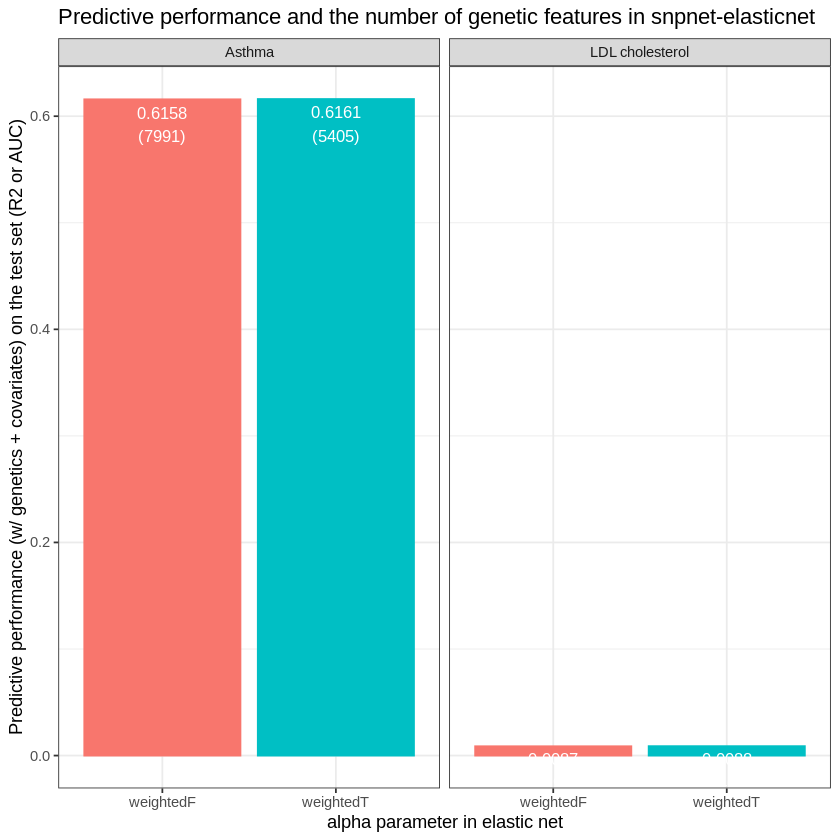

In [19]:
p_pred